In [5]:
import serial
serialPort = serial.Serial(port = "COM4",baudrate=115200, bytesize=8,stopbits=serial.STOPBITS_ONE)

In [9]:
    #---------------------------------------Inverse Kinematics Project Voyager--------------------------------------------------
    #---------------------------------------------------Selecting Values------------------------------------------------------#
#X = [0.2,0.15,0.1,0,-0.1,-0.15,-0.2]  
#Y = [0,0.1,0.15,0.2,0.15,0.1,0]
#Z = [0,0.15,0.2,0.3,0.2,0.15,0]
import numpy as np
X = [-0.3]
Y = [0.3]
Z = [0]

for k in np.arange(0,len(X),1):
        print('Coordinate ',k)
        Xe = X[k]
        Ye = Y[k]
        Ze = Z[k]

        import numpy as np
        import matplotlib.pyplot as plt
        import sys
        from IPython.display import clear_output
        import numpy as np
        import keyboard
        import serial
        import struct
        import math
        import time
        def Inverse_Kinematics(X,Y,Z,phi):
            if X>0:
                X = X + 0.015
            if X<0:
                X = X - 0.015
            phi = np.radians(phi)#phi = np.arccos((-l2 - l3 + actuallength)/l4)
            Offset2 = 0
            l2 = 0.125
            l3 = 0.125
            l4 = 0.20
            d = 0.059
            Theta2_list = []
            Theta3_list = []
            error_net = []
            xo = []
            yo = []
            zo = []
            actuallength = (X**2 + Y**2 + Z**2)**0.5 #maxlength = l2+l3+l4*np.cos(phi)
            MAX = l2 + l3 + l4
            Ymax = l2 + l3
            if MAX < actuallength:
                print('The following request is impossible to satisfy')
                sys.exit()  
            Theta1 = np.arctan2(Z,X)
            for i in np.arange(30,151,1):
                Theta2 = np.radians(i)  
                C3 = X/np.cos(Theta1) - l4*np.cos(phi) - l2*np.cos(Theta2)
                S3 = Y - l4*np.sin(phi) - l2*np.sin(Theta2) - d
                Theta3 = np.arctan2(S3, C3)
                Theta2_list.append(Theta2)
                Theta3_list.append(Theta3)
                Xo = np.cos(Theta1)*(l2 * np.cos(Theta2) + l3 * np.cos(Theta3) + l4 * np.cos(phi))
                Yo = d + l2 * np.sin(Theta2) + l3 * np.sin(Theta3) + l4 * np.sin(phi)
                Zo = np.sin(Theta1)*(l2 * np.cos(Theta2) + l3 * np.cos(Theta3) + l4 * np.cos(phi))
                errorX = X - Xo
                errorY = Y - Yo
                errorZ = Z - Zo
                xo.append(Xo)
                yo.append(Yo)
                zo.append(Zo)
                error_net.append((errorX**2 + errorY**2 + errorZ**2)**(1/2))    
            min_index = error_net.index(min(error_net))
            error = np.round(error_net[min_index],4)
            Theta2_optimised = Theta2_list[min_index]
            Theta3_optimised = Theta3_list[min_index]
            Xe = xo[min_index]
            Ye = yo[min_index]
            Ze = zo[min_index]
            Theta = np.round([np.degrees(Theta1), np.degrees(Theta2_optimised), np.degrees(Theta3_optimised), np.degrees(phi)], 2)
            Theta2f = Theta[1]
            Theta3f = Theta[2]
            Theta4f = Theta[3]
            Theta2m = Theta2f - Offset2
            Theta3m = 90 + Theta3f - Theta2f
            Theta4m = 90 + Theta3f - Theta4f
            Theta_motors = np.round([Theta[0], Theta2m, Theta3m, Theta4m, 0])
            return Theta_motors, error,Xe,Ye,Ze,Theta

        #---------------------------------------------iterating for optimal phi--------------------------------------------------
        e_list = []
        T1 = []
        T2 = []
        T3 = []
        T4 = []
        T5 = []
        xi = []
        time1 = time.time()
        phioptimization = np.arange(-90,90,1)   
        for phi in phioptimization:
            if Xe == 0:
                Tim,ei,x,y,z,Ta = Inverse_Kinematics(Ze,Ye,Xe,phi)
                Tim[0] = 90
            else:
                Tim,ei,x,y,z,Ta = Inverse_Kinematics(Xe,Ye,Ze,phi)
            Possible = True
            for k in np.arange(0,len(Tim),1):
                if (Tim[k] < 0) or (Tim[k] > 180):
                    Possible = False
            if Possible:
                e_list.append(ei)
                T1.append(Tim[0])
                T2.append(Tim[1])
                T3.append(Tim[2])
                T4.append(Tim[3])
                T5.append(Tim[4])
                xi.append(phi)
                if ei < 0.001:
                    break                      
        if e_list == []:
            print('This cooridnate cannot be reached')
            sys.exit()
        
        min_error_index = e_list.index(min(e_list))
        error_motor = np.round(e_list[min_error_index],9)
        phi_final = xi[min_error_index]
        Theta_final_choice = np.round([T1[min_error_index] + 3, T2[min_error_index], T3[min_error_index], T4[min_error_index], 90])
        print('Theta absolute angles:[',Ta[0],Ta[1]-90,Ta[2],Ta[3],']')
        #print('\nTheta motor angles:',Theta_final_choice_choice)
        #print('The Theta final choice for the motors movement which is possible and returns the lowest error is:', Theta_final_choice)
        #print('The minimum error found was found to be = ',error_motor,'m')
        #print('The final optimised phi position chosen is ',phi_final,' degrees')
        #----------------------------------------------Sending motors their instructions-------------------------------------------                  
        Theta = np.array(Theta_final_choice)
        Time = Theta*0.01031 + 0.544
        RB = abs(Time*24e3/16)
        RB_array = np.array(RB, dtype = np.single) # this converts the array values to float values.
        RB_binary = RB_array.tobytes()
        for i in np.arange(1,6,1):
            voyager = np.array([160,i,RB_binary[(i-1)*4],RB_binary[(i-1)*4+1],RB_binary[(i-1)*4+2],RB_binary[(i-1)*4+3],176,177], dtype = np.uint8)
            #serialPort.write(voyager.data)       
        time2 = time.time()

        ptime = time2-time1
       #print('\nTotal processing time = ',np.round(ptime,3),'s')
        #print('-------------------------------------------------')
        #print('The coordinates: \nX:',Xe, 'X_real :',x,'\nY:',Ye,' Y_real:',y,'\nZ:',Ze,' Z_real:',z)
        #print('\nAbsolute Coordinates: \nX = {}\nY = {}\nZ = {}'.format(Xe,Ye,Ze))
        #print('\nSimulation Coordinates: \nX = {}\nY = {}\nZ = {}'.format(x,y,z),'\n')


Coordinate  0
Theta absolute angles:[ 180.0 -22.0 56.38 6.0 ]


In order to attain the following absolute coorindates of: 
X =  -0.3 cm
Y =  0.3 cm
Z =  0 cm

The absoulte Theta angles =  [180.    51.    79.66   6.  ]


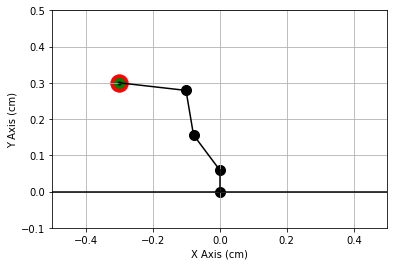

Final actual motor values are: [180.  42. 119. 164.   0.]
Error =  2e-05 m


In [10]:
def Inverse_Kinematics(X,Y,Z,phi):        
    phi = np.radians(phi)
    Offset2 = 9
    l2 = 0.125
    l3 = 0.125
    l4 = 0.20
    d = 0.059
    Theta2_list = []
    Theta3_list = []
    error_net = []
    xo = []
    yo = []
    zo = []
    actuallength = (X**2 + Y**2 + Z**2)**0.5
    MAX = l2 + l3 + l4
    Ymax = l2 + l3
    if MAX < actuallength:
        print('The following request is impossible to satisfy')
        sys.exit()     
    Theta1 = np.arctan2(Z,X)
    for i in np.arange(30,151,1):
        Theta2 = np.radians(i)  
        C3 = X/np.cos(Theta1) - l4*np.cos(phi) - l2*np.cos(Theta2)
        S3 = Y - l4*np.sin(phi) - l2*np.sin(Theta2) - d
        Theta3 = np.arctan2(S3, C3)
        Theta2_list.append(Theta2)
        Theta3_list.append(Theta3)
        Xo = np.cos(Theta1)*(l2 * np.cos(Theta2) + l3 * np.cos(Theta3) + l4 * np.cos(phi))
        Yo = d + l2 * np.sin(Theta2) + l3 * np.sin(Theta3) + l4 * np.sin(phi)
        Zo = np.sin(Theta1)*(l2 * np.cos(Theta2) + l3 * np.cos(Theta3) + l4 * np.cos(phi))
        errorX = X - Xo
        errorY = Y - Yo
        errorZ = Z - Zo
        xo.append(Xo)
        yo.append(Yo)
        zo.append(Zo)
        error_net.append((errorX**2 + errorY**2 + errorZ**2)**(1/2))      
    min_index = error_net.index(min(error_net))
    error = np.round(error_net[min_index],6)
    Theta2_optimised = Theta2_list[min_index]
    Theta3_optimised = Theta3_list[min_index]
    Xe = xo[min_index]
    Ye = yo[min_index]
    Ze = zo[min_index]
    Theta = np.round([np.degrees(Theta1), np.degrees(Theta2_optimised), np.degrees(Theta3_optimised), np.degrees(phi)], 2)
    Theta2f = Theta[1]
    Theta3f = Theta[2]
    Theta4f = Theta[3]
    Theta2m = Theta2f - Offset2
    Theta3m = 90 + Theta3f - Theta2f
    Theta4m = 90 + Theta3f - Theta4f
    Theta_motors = np.round([Theta[0], Theta2m, Theta3m, Theta4m, 0])
    print('In order to attain the following absolute coorindates of: \nX = ',X,'cm\nY = ',Y,'cm\nZ = ',Z,'cm')
    print('\nThe absoulte Theta angles = ', Theta)
    #print('\nError = ', error,'cm')
    #print('\nTheta Motors: ',Theta_motors)
    l1x = np.cos(Theta1)*l2*np.cos(Theta2_optimised)   
    l1y = d + l2*np.sin(Theta2_optimised)
    l2x = l1x + np.cos(Theta1)*l3*np.cos(Theta3_optimised)
    l2y = l1y + l3*np.sin(Theta3_optimised)
    l3x = l2x + np.cos(Theta1)*l4*np.cos(phi)
    l3y = l2y + l4*np.sin(phi)
    plt.figure()
    plt.scatter(X, Y,c = 'r', s=300)
    plt.scatter(Xe, Ye, c = 'g', s=100)
    plt.scatter(0, 0,c = 'k', s=100)
    plt.scatter(0, d,c = 'k', s=100)
    plt.scatter(l1x, l1y,c = 'k', s=100)
    plt.scatter(l2x, l2y,c = 'k', s=100)
    plt.scatter(l3x, l3y,c = 'k', s=10)
    plt.xlim(-0.50,0.50)
    plt.ylim(-0.10,0.50)
    plt.plot([-0.50,0.50], [0,0], 'k')
    plt.plot([0,0],[0,d], 'k')
    plt.plot([0,l1x],[d,l1y], 'k')
    plt.plot([l1x,l2x],[l1y,l2y], 'k')
    plt.plot([l2x,l3x],[l2y,l3y], 'k')
    plt.ylabel('Y Axis (cm)')
    plt.xlabel('X Axis (cm)')
    plt.grid(True)
    plt.show()    
    return Theta_motors, error
if Xe == 0:
    T,e = Inverse_Kinematics(Ze,Ye,Xe,phi_final)
    T[0] = 90
    print('X = 0')
    print('Final actual motor values are:',T)
    print('Error = ',e,'m')
else:
    T,e = Inverse_Kinematics(Xe,Ye,Ze,phi_final)
    print('Final actual motor values are:',T)
    print('Error = ',e,'m')
    

In [36]:
X_start = 
Y_start = 
Z_start = 

X_end = 
Y_end = 
Z_end =

e_list = []
T1 = []
T2 = []
T3 = []
T4 = []
T5 = []
xi = []
time1 = time.time()
phioptimization = np.arange(-90,90,1)   
for phi in phioptimization:
    if Xe == 0:
        Tim,ei,x,y,z = Inverse_Kinematics(Z_start,Y_start,X_start,phi)
        Tim[0] = 90
    else:
        Tim,ei,x,y,z = Inverse_Kinematics(X_start,Y_start,Z_start,phi)
    Possible = True
    for k in np.arange(0,len(Tim),1):
        if (Tim[k] < 0) or (Tim[k] > 180):
            Possible = False
    if Possible:
        e_list.append(ei)
        T1.append(Tim[0])
        T2.append(Tim[1])
        T3.append(Tim[2])
        T4.append(Tim[3])
        T5.append(Tim[4])
        xi.append(phi)
        if ei < 0.001:
            print('The optimal was found sooner using another approach')
            break                      
if e_list == []:
    print('This cooridnate cannot be reached')
    sys.exit()
min_error_index = e_list.index(min(e_list))
error_motor = np.round(e_list[min_error_index],4)
phi_final = xi[min_error_index]
Theta_final_choice = np.round([T1[min_error_index], T2[min_error_index], T3[min_error_index], T4[min_error_index], 90])

print('Total processing time = ',ptime)
print('The coordinates: \nX:',Xe, 'X_real :',x,'\nY:',Ye,' Y_real:',y,'\nZ:',Ze,' Z_real:',z)




route = True
Theta = np.round(Theta)
while route:
    if Theta[0] != Theta_scan[0]:
        Theta[0] = Theta[0] - 1
    if Theta[1] != Theta_scan[1]:
        if (Theta_scan[1] - Theta[1]) > 0:
            Theta[1] = Theta[1] + 1
        else:
            Theta[1] = Theta[1] - 1
    if Theta[2] != Theta_scan[2]:
        if (Theta_scan[2] - Theta[2]) > 0:
            Theta[2] = Theta[2] + 1
        else:
            Theta[2] = Theta[2] - 1
    if Theta[3] != Theta_scan[3]:
        if (Theta_scan[3] - Theta[3]) > 0:
            Theta[3] = Theta[3] + 1
        else:
            Theta[3] = Theta[3] - 1
    Theta[4] = 0
    if (Theta[0] == Theta_scan[0]) and (Theta[1] == Theta_scan[1]) and(Theta[2] == Theta_scan[2]) and (Theta[3] == Theta_scan[3]):
        route = False
        print('Home route success')
    Time = Theta*0.01031 + 0.544
    RB = abs(Time*24e3/16)
    RB_array = np.array(RB, dtype = np.single) # this converts the array values to float values.
    RB_binary = RB_array.tobytes()
    for i in np.arange(1,6,1):
        voyager = np.array([160,i,RB_binary[(i-1)*4],RB_binary[(i-1)*4+1],RB_binary[(i-1)*4+2],RB_binary[(i-1)*4+3],176,177], dtype = np.uint8)
        serialPort.write(voyager.data)  
    time.sleep(0.05)

m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2

This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the 

m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is

m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is

m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is

This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is afte

This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit

This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
m  0
This is after break?
m  1
This is after break?
m  2
This is the m row and is meant to exit now
This is the l row
this is the k row
m  0
This is after break?
m  1
This is afte